# Preamble

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import cmocean.cm as ocm
import seaborn as sns

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
ext_dir = os.path.join(data_dir,'analysis','external')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','relation_melting','figures')
tab_dir = os.path.join(os.pardir,os.pardir,'reports','relation_melting','tables')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)
sys.path.append('/home/ubuntu/bigStick/antarctic_melting/src/tools')

from visualization.shiftedColorMap import shiftedColorMap
from log_progress import log_progress

In [101]:
s2a = 3600*24*365.25

grid_path = os.path.join(int_dir,'grd2_dV.nc')
star_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_star_avg.nc')

grd = xr.open_dataset(grid_path)
stars = xr.open_dataset(star_path).squeeze()

obs_m_path = os.path.join(data_dir,'analysis','processed','susheel_on_waom2grd.nc')
obs_m = xr.open_dataarray(obs_m_path)

mask = (grd.mask_rho ==1) & (grd.zice <0)
df = pd.DataFrame.from_dict({'Tstar':stars.Tstar.values[mask],
                             'ustar':stars.ustar.values[mask]*100,
                             'm':stars.m.values[mask]*s2a,
                             'm_obs':obs_m.values[mask]})

In [114]:
import h5py
path = os.path.join(ext_dir,'susheel','ANT_iceshelf_melt_rates_CS2_2010-2018_v0_5km.h5')
sus = {}
f = h5py.File(path)
for k, v in f.items():
    sus[k] = np.flipud(np.rot90(np.array(v)))

In [119]:
df_obs = pd.DataFrame.from_dict({'m_obs_raw':sus['w_b'].flatten()}).dropna()

In [3]:
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
     # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    Rsquared = ssreg / sstot
    
    xp =np.linspace(min(x),max(x),100)
    
    return xp,p,Rsquared

def plot_regres(ax,x_all,y_all,deg):
    xp,p,Rsquared = polyfit(x_all,y_all,deg)        
    ax.plot(xp,p(xp),'k-')
    ax.text(0.05,0.8,str(p)+'\n($r^2$ = %.2f)' %(Rsquared),transform=ax.transAxes)
    
    return p
    
def scatter_shelves_avg(x_all,y_all,title,xlab,ylab,deg,save=False):
    
    plt.close()
    fig,ax = plt.subplots()
    
    ax.scatter(x_all,y_all)
        
    p = plot_regres(ax,x_all,y_all,deg)
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.set_xlim([min(x_all)-0.5*np.std(x_all),max(x_all)+0.5*np.std(x_all)])
    ax.set_ylim([min(y_all)-0.5*np.std(y_all),max(y_all)+0.5*np.std(y_all)])
   
    if save:
        plt.savefig(os.path.join(fig_dir,'scatter_shelves_avg_'+title.replace('/','_')+'.png'),format='png',bbox_inches = "tight")    

    plt.show()
    
    return p

# Annual averages - 2 km resolution

## Overview Statistics

In [121]:
df.describe()

,Tstar,ustar,m,m_obs
count,403008.000000,403008.000000,403008.000000,335520.000000
mean,0.086026,0.389921,0.819378,0.605247
std,0.182542,0.299317,2.091806,2.207414
min,-0.808862,0.100000,-16.712975,-19.795664
25%,0.004133,0.197669,0.034583,-0.179318
50%,0.019266,0.307255,0.137072,0.199323
75%,0.084989,0.499710,0.716223,0.808367
max,2.593425,3.835577,62.995228,88.089296


In [122]:
df_obs.describe()

,m_obs_raw
count,5.633341e+06
mean,6.765759e-01
std,2.608326e+00
min,-1.982391e+01
25%,-1.727717e-01
50%,2.171330e-01
75%,8.694445e-01
max,2.724705e+02


In [83]:
sample = df.sample(10000)
sample.describe()

,Tstar,ustar,m,m_obs
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.085584,0.390678,0.809116,1.006769
std,0.182653,0.299477,1.965527,2.634108
min,-0.375093,0.100000,-6.877941,-8.265623
25%,0.004143,0.198267,0.034449,-0.045864
50%,0.018823,0.308314,0.134667,0.386326
75%,0.085142,0.500572,0.714845,1.062391
max,2.077717,3.639203,33.319267,27.932381


## Frequency distributions

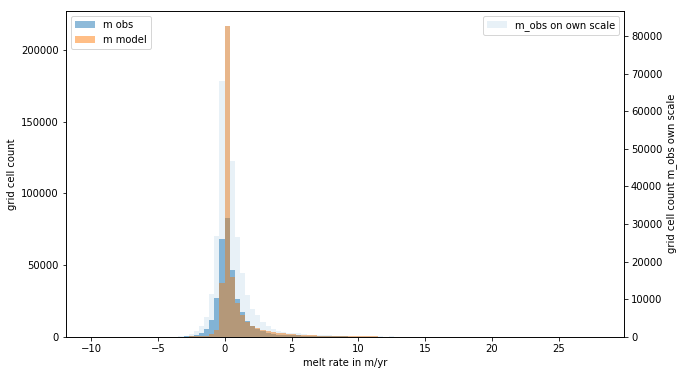

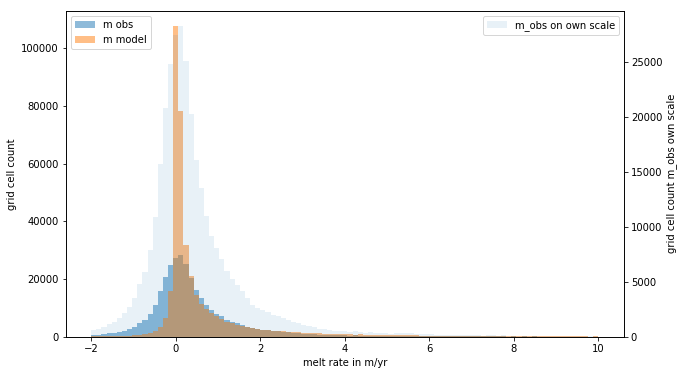

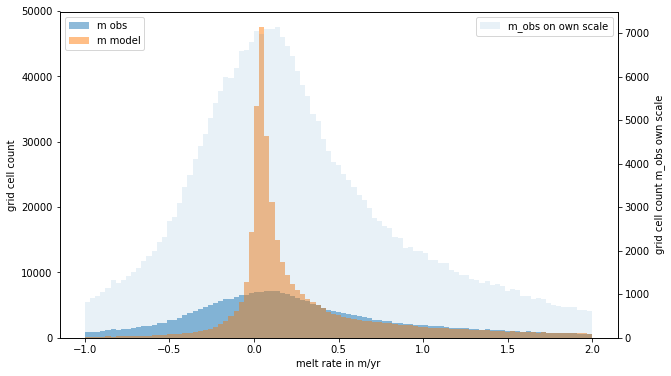

In [136]:
%matplotlib inline

def plot_hist_comp(bins):
    plt.close()
    fig,ax = plt.subplots(figsize=(10,6))
    ax.set_xlabel('melt rate in m/yr')
    ax.set_ylabel('grid cell count')
    ax.hist(df.m_obs, bins, alpha=0.5, label='m obs')
    ax.hist(df.m, bins, alpha=0.5, label='m model')
    plt.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.set_ylabel('grid cell count m_obs own scale')
    #ax2.hist(df_obs.m_obs_raw,bins,alpha=0.5, label = 'm obs raw')
    ax2.hist(df.m_obs, bins, alpha =0.1, label='m_obs on own scale')
    plt.legend(loc='upper right')
    plt.show()
    
plot_hist_comp(np.linspace(-10,28,100))  
plot_hist_comp(np.linspace(-2,10,100))
plot_hist_comp(np.linspace(-1,2,100))

Text(0.5,1,'Frequency distribution of ustar')

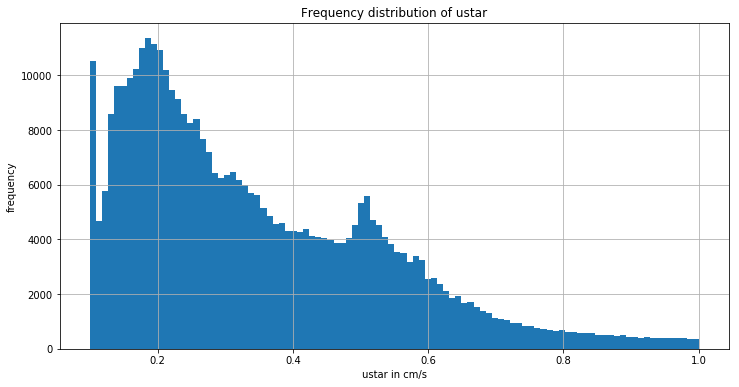

In [42]:
ustar_range = (df.ustar>=0) & (df.ustar<1)
ax = (df.ustar[ustar_range]).hist(bins=100,figsize=(12,6))
ax.set_xlabel("ustar in cm/s")
ax.set_ylabel('frequency')
ax.set_title('Frequency distribution of ustar')

In [148]:
mask = (grd.mask_rho ==1) & (grd.zice <0)
df_wc = pd.DataFrame.from_dict({'wc':wc.values[mask]})
df = pd.concat([df, df_wc], axis=1, sort=False)

In [151]:
sample = df.sample(10000)

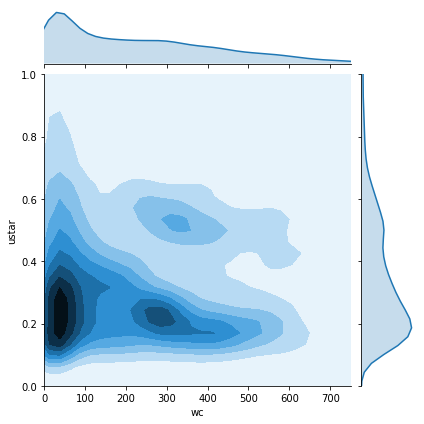

In [153]:
sns.jointplot('wc','ustar',sample,kind='kde',xlim=[0,750],ylim=[0,1])

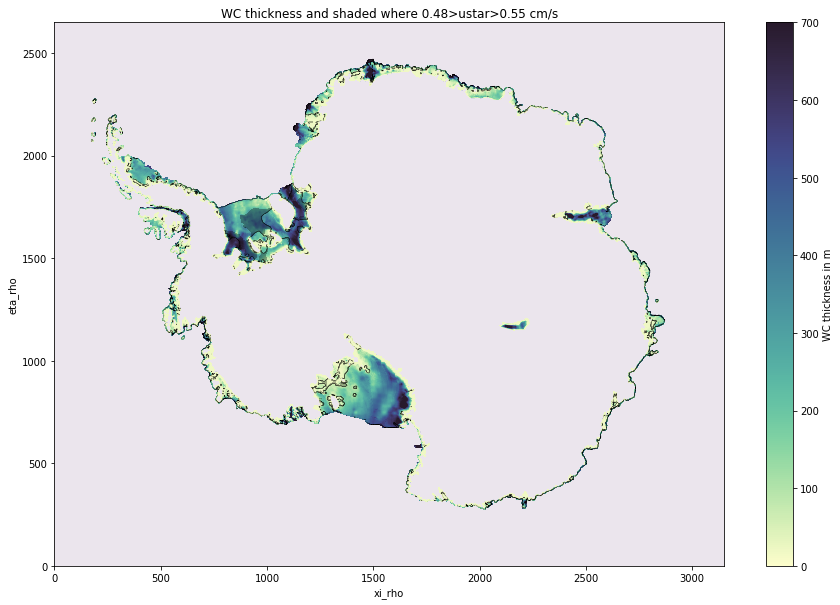

In [186]:
plt.close()
fig, ax = plt.subplots(figsize=(15,10))
mask_zice.plot.contourf(alpha=0.1,ax=ax,add_colorbar=False)
wc_plt = wc.plot(ax=ax,vmin=0,vmax=700,cmap=ocm.deep,add_colorbar=False)
grd.mask_rho.where(mask_ustar).plot.contourf(ax=ax,alpha=0.3,add_colorbar=False,colors='k')
stars.ustar.plot.contour(ax=ax,add_colorbar=False,levels=np.arange(0.0048,0.0055,2),
                         colors=('k','k'),linewidths=0.5)
plt.colorbar(wc_plt,ax=ax,label='WC thickness in m')
ax.set_title('WC thickness and shaded where 0.48>ustar>0.55 cm/s')
plt.show()

ValueError: x must be a dimension name if y is not supplied

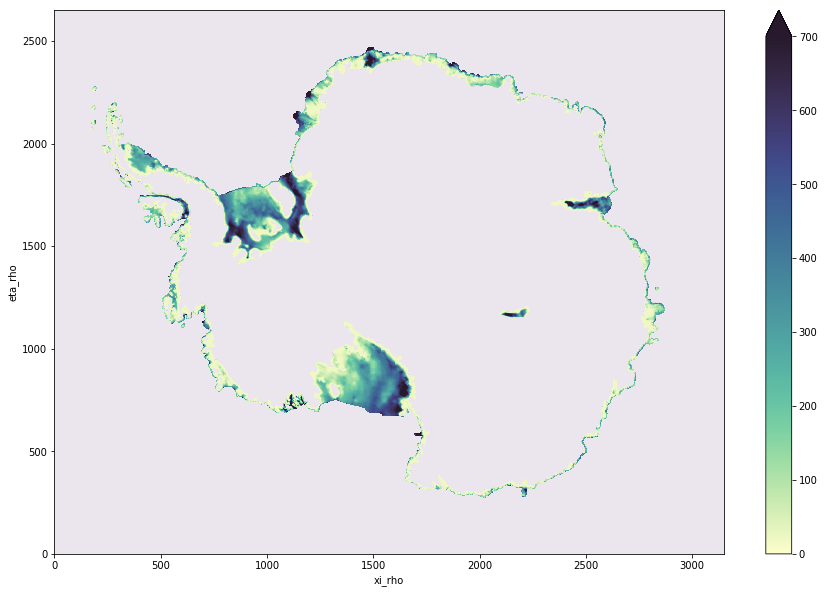

In [178]:
mask_zice = (grd.mask_rho==1) & (grd.zice<0)
mask_ustar = (stars.ustar>=0.0048) & (stars.ustar<=0.0055)
wc = (grd.h + grd.zice).where(mask_zice)
%matplotlib inline
plt.close()
fig, ax = plt.subplots(figsize=(15,10))
mask_zice.plot.contourf(alpha=0.1,ax=ax,add_colorbar=False)
wc_plt = wc.plot(ax=ax,vmin=0,vmax=700,cmap=ocm.deep)
ustar_plt = stars.ustar.where(mask_ustar).plot.contour(0.0048,ax=ax,cmap = 'bwr')
plt.colorbar(ustar_plt, ax=ax, label = '')
ax.set_title('WC thickness where 0.48>ustar>0.55 cm/s')
plt.show()

In [184]:
m_range = (df.m>=-0.2) & (df.m <0.8)
u_range = (df.ustar>=0.0) & (df.ustar<1.0)

## Relationships and regression

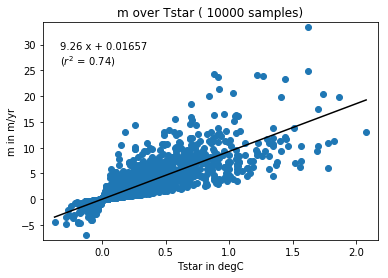

poly1d([9.26043785, 0.01657002])

In [137]:
x=sample.Tstar
y=sample.m
scatter_shelves_avg(x,y,'m over Tstar ( 10000 samples)','Tstar in degC','m in m/yr',1)

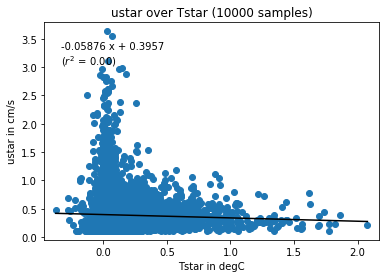

poly1d([-0.05876261,  0.39570725])

In [141]:
x = sample.Tstar
y = sample.ustar
scatter_shelves_avg(x,y,'ustar over Tstar (10000 samples)','Tstar in degC','ustar in cm/s',1)

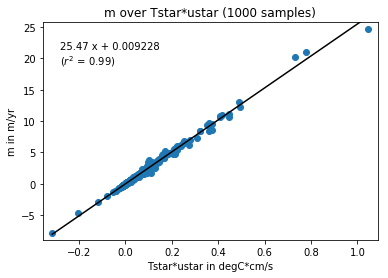

poly1d([2.54732395e+01, 9.22782869e-03])

In [187]:
x = sample.Tstar*sample.ustar
y = sample.m
scatter_shelves_avg(x,y,'m over Tstar*ustar (1000 samples)','Tstar*ustar in degC*cm/s','m in m/yr',1)

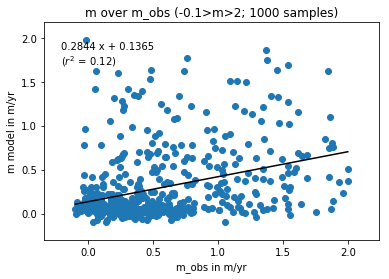

poly1d([0.28438528, 0.13650186])

In [217]:
m_range = (sample.m_obs>-0.1) & (sample.m_obs < 2) & (sample.m>-0.1) & (sample.m < 2) 
x = sample.m_obs[m_range]
y = sample.m[m_range]
scatter_shelves_avg(x,y,'m over m_obs (-0.1>m>2; 1000 samples)','m_obs in m/yr','m model in m/yr',1)

# Ice shelf averages

## Frequency distribution

In [58]:
is_masks_path = os.path.join(int_dir,'shelves2.npy')
is_masks = np.load(is_masks_path,allow_pickle=True).item()
is_masks = {k: v['mask'] for k, v in is_masks.items() if v['mask'].any()}

In [59]:
is_stars = {k:{} for k,v in is_masks.items()}

dA = (grd.pm*grd.pn)**-1

for k,v in log_progress(is_masks.items(),every=2):
    weights = dA.where(v)/dA.where(v).sum()
    for name in ['m','Tstar','ustar']:        
        is_stars[k][name]=(stars[name]*weights).sum().values   

In [60]:
for k,v in log_progress(is_masks.items(),every=2):
    weights = dA.where(v)/dA.where(v).sum()
    for name in ['m_obs']:        
        is_stars[k][name]=(obs_m*weights).sum().values

In [66]:
m = []
Tstar = []
ustar = []
m_obs = []
for k,v in is_stars.items():
    m.append(v['m']*s2a)
    Tstar.append(v['Tstar'])
    ustar.append(v['ustar']*100)
    m_obs.append(v['m_obs'])

In [67]:
is_df = pd.DataFrame.from_dict({'m':m,'Tstar':Tstar,'ustar':ustar,'m_obs':m_obs}).astype(float)

In [223]:
is_df.describe()

,m,Tstar,ustar,m_obs
count,160.000000,160.000000,160.000000,160.000000
mean,1.699764,0.210476,0.263266,3.148903
std,1.905576,0.180930,0.116237,4.745044
min,0.068184,0.007145,0.100568,-4.286353
25%,0.494824,0.077294,0.181115,0.431319
50%,1.037784,0.159161,0.242688,1.878043
75%,2.084917,0.262714,0.312172,4.639196
max,10.870779,0.891096,0.739420,22.581017


Text(0.5,1,'Frequency distribution of ice shelf average melting')

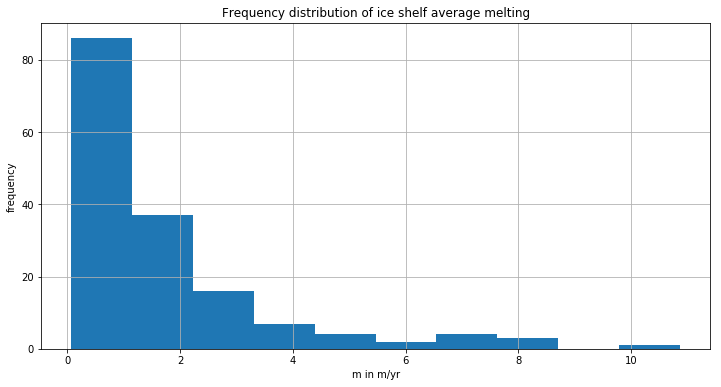

In [133]:
ax = is_df.m.hist(figsize=(12,6))
ax.set_xlabel("m in m/yr")
ax.set_ylabel('frequency')
ax.set_title('Frequency distribution of ice shelf average melting')

Text(0.5,1,'Frequency distribution of ice shelf average melting observations')

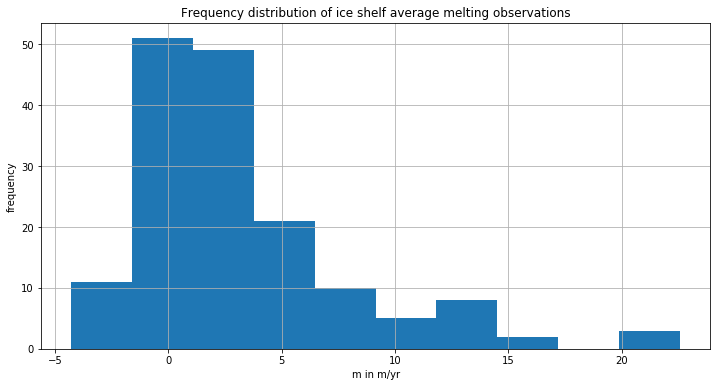

In [224]:
ax = is_df.m_obs.hist(figsize=(12,6))
ax.set_xlabel("m in m/yr")
ax.set_ylabel('frequency')
ax.set_title('Frequency distribution of ice shelf average melting observations')

In [ ]:
is_df[['m','m_obs']].hist(shar)

Text(0.5,1,'Frequency distribution of ice shelf average Tstar')

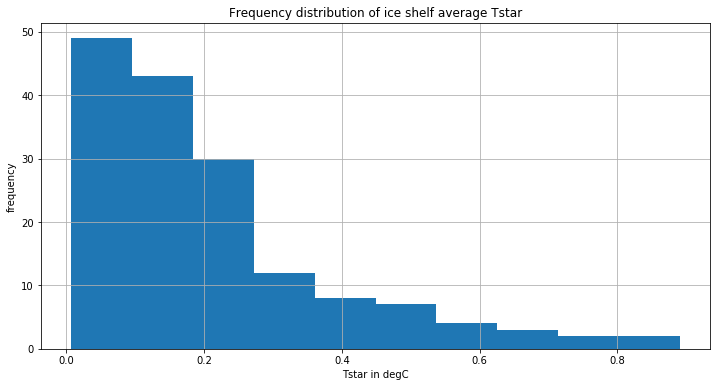

In [134]:
ax = is_df.Tstar.hist(figsize=(12,6))
ax.set_xlabel("Tstar in degC")
ax.set_ylabel('frequency')
ax.set_title('Frequency distribution of ice shelf average Tstar')

Text(0.5,1,'Frequency distribution of ice shelf average ustar')

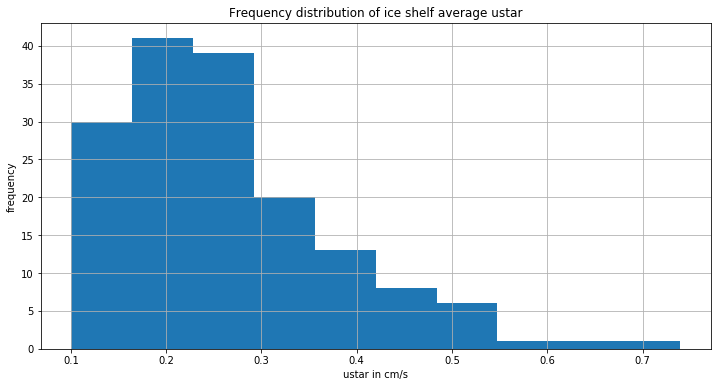

In [135]:
ax = is_df.ustar.hist(figsize=(12,6))
ax.set_xlabel("ustar in cm/s")
ax.set_ylabel('frequency')
ax.set_title('Frequency distribution of ice shelf average ustar')

## Relations and regression

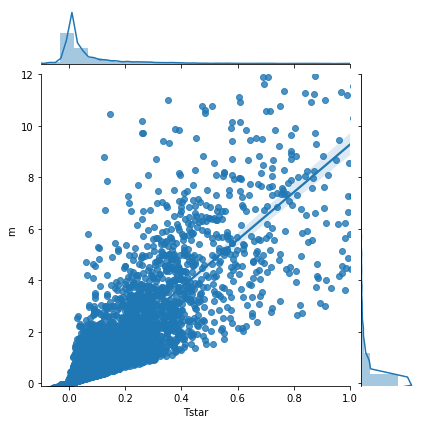

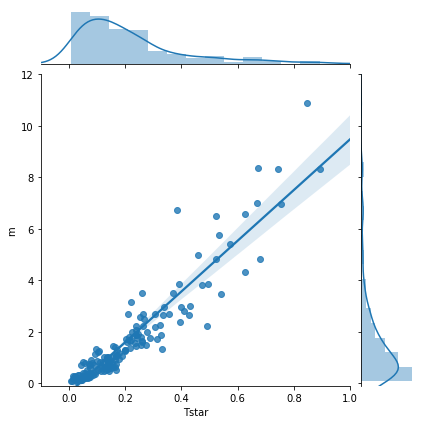

In [84]:
sns.jointplot('Tstar','m',sample,kind='reg',xlim=[-0.1,1],ylim=[-0.1,12])
sns.jointplot('Tstar','m',is_df,kind='reg',xlim=[-0.1,1],ylim=[-0.1,12])


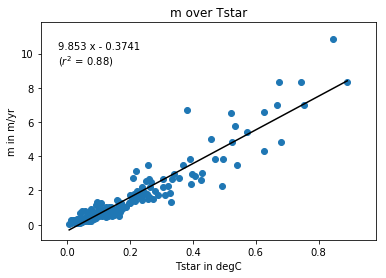

poly1d([ 9.85306914, -0.37406653])

In [138]:
scatter_shelves_avg(is_df.Tstar,is_df.m,'m over Tstar','Tstar in degC','m in m/yr',1)

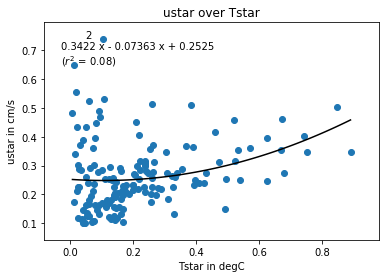

poly1d([ 0.3422411 , -0.07363047,  0.25246833])

In [161]:
scatter_shelves_avg(is_df.Tstar,is_df.ustar,'ustar over Tstar','Tstar in degC','ustar in cm/s',2)

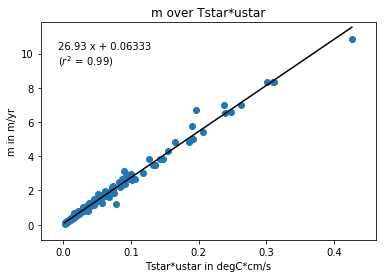

poly1d([26.93277976,  0.06333369])

In [162]:
x = is_df.Tstar*is_df.ustar
y = is_df.m
scatter_shelves_avg(x,y,'m over Tstar*ustar','Tstar*ustar in degC*cm/s','m in m/yr',1)

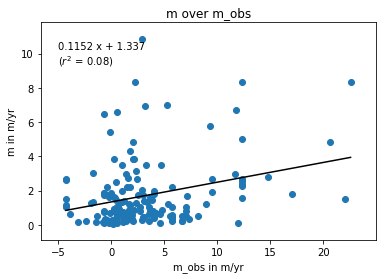

poly1d([0.11521745, 1.33695578])

In [225]:
x = is_df.m_obs
y = is_df.m
scatter_shelves_avg(x,y,'m over m_obs','m_obs in m/yr','m in m/yr',1)